time [s]    T1 [K]      T2 [K]      V1 [m^3]    V2 [m^3]    V1+V2 [m^3]  X(CO)     
     0.004      3012.7    305.2526      0.1213      0.4787         0.6     0.07339
     0.008      2984.6    308.0197       0.132       0.468         0.6     0.07206
     0.012      2970.1    309.5919      0.1379      0.4621         0.6     0.07136
     0.016      2962.0    310.5119      0.1414      0.4586         0.6     0.07096
     0.020      2957.4    311.0581      0.1434      0.4566         0.6     0.07073
     0.024      2954.7    311.3847      0.1446      0.4554         0.6     0.07059
     0.028      2953.1    311.5808      0.1453      0.4547         0.6     0.07051
     0.032      2952.1    311.6989      0.1457      0.4543         0.6     0.07046
     0.036      2951.5    311.7700       0.146       0.454         0.6     0.07043
     0.040      2951.2    311.8130      0.1461      0.4539         0.6     0.07042
     0.044      2951.0    311.8389      0.1462      0.4538         0.6      0.0704
   

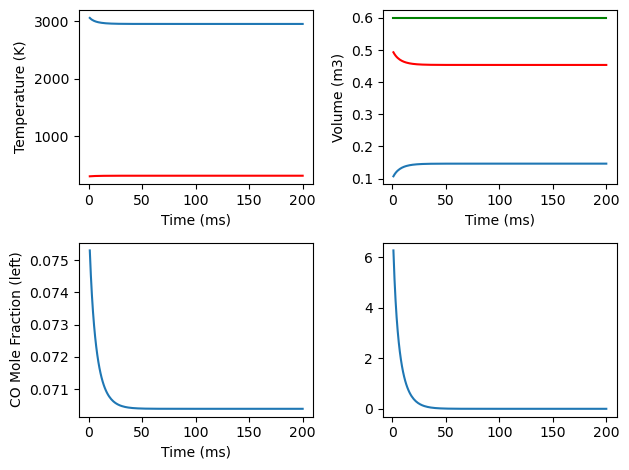

In [15]:
"""
Two reactors separated by a piston that moves with a speed proportional to the pressure
difference between the reactors.

Gas 1: a stoichiometric H2/O2/Ar mixture
Gas 2: a wet CO/O2 mixture

    -------------------------------------
    |          ||                       |
    |          ||                       |
    |  gas 1   ||        gas 2          |
    |          ||                       |
    |          ||                       |
    -------------------------------------

The two volumes are connected by an adiabatic free piston. The piston speed is
proportional to the pressure difference between the two chambers.

Note that each side uses a *different* reaction mechanism

Requires: cantera >= 2.5.0, matplotlib >= 2.0
Keywords: combustion, reactor network, plotting
"""

import sys
import matplotlib.pyplot as plt
import cantera as ct

fmt = '{:10.3f}  {:10.1f}  {:10.4f}  {:10.4g}  {:10.4g}  {:10.4g}  {:10.4g}'
print('{:10}  {:10}  {:10}  {:10}  {:10}  {:10}  {:10}'.format(
    'time [s]', 'T1 [K]', 'T2 [K]', 'V1 [m^3]', 'V2 [m^3]', 'V1+V2 [m^3]', 'X(CO)'))

gas1 = ct.Solution('Jerzembeck.yaml')
gas1.TP = 2000.0, ct.one_atm
gas1.set_equivalence_ratio(1.0, 'IXC8H18', 'O2:1, N2:3.76')

gas2 = ct.Solution('air.yaml')
gas2.TPX = 300.0, ct.one_atm, 'O2:1, N2:3.76'

r1 = ct.IdealGasReactor(gas1)
r1.volume = 0.1
r2 = ct.IdealGasReactor(gas2)
r2.volume = 0.5


# The wall is held fixed until t = 0.1 s, then released to allow the pressure to
# equilibrate.
def v(t):
        return (r1.thermo.P - r2.thermo.P) * 1e-4
    
def vitesse(t):
        return (states1.P - states2.P) * 1e-4


w = ct.Wall(r1, r2, velocity=v)

net = ct.ReactorNet([r1, r2])

states1 = ct.SolutionArray(r1.thermo, extra=['t', 'volume'])
states2 = ct.SolutionArray(r2.thermo, extra=['t', 'volume'])

for n in range(200):
    time = (n+1)*0.001
    net.advance(time)
    if n % 4 == 3:
        print(fmt.format(time, r1.T, r2.T, r1.volume, r2.volume,
                         r1.volume + r2.volume, r1.thermo['CO'].X[0]))

    states1.append(r1.thermo.state, t=1000*time, volume=r1.volume)
    states2.append(r2.thermo.state, t=1000*time, volume=r2.volume)

# plot the results if matplotlib is installed.

plt.subplot(2, 2, 1)
plt.plot(states1.t, states1.T, '-', states2.t, states2.T, 'r-')
plt.xlabel('Time (ms)')
plt.ylabel('Temperature (K)')
plt.subplot(2, 2, 2)
plt.plot(states1.t, states1.volume, '-', states2.t, states2.volume, 'r-',
         states1.t, states1.volume + states2.volume, 'g-')
plt.xlabel('Time (ms)')
plt.ylabel('Volume (m3)')
plt.subplot(2, 2, 3)
plt.plot(states1.t, states1('CO').X)
plt.xlabel('Time (ms)')
plt.ylabel('CO Mole Fraction (left)')
plt.subplot(2, 2, 4)
plt.plot(states1.t, vitesse(states1.t))
plt.tight_layout()
plt.show()

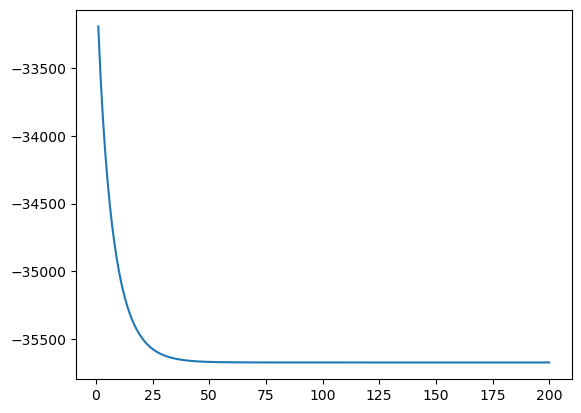

In [16]:
travail = []
for i in range(len(states1.t)):
    travail.append(states1.volume[i]*states1.P[i] - states2.volume[i]*states2.P[i])

plt.plot(states1.t, travail)